- Description of Notebook: genome quality 
- Date: 5 Jul 2021
- Last modified : 15 Dec 2021
- By: Yannis Nevers and Natasha Glover

Before running: You need to load the biopython module
And then follow these instructions to access it on the nam server: https://amber-md.github.io/pytraj/latest/tutorials/remote_jupyter_notebook

In [1]:
import sys
#sys.path.append("/home/psaroudakis/.local/lib/python3.9/site-packages/")
sys.path.extend(['/opt/Bio/python/3.6.1/lib/python36.zip', '/opt/Bio/python/3.6.1/lib/python3.6', '/opt/Bio/python/3.6.1/lib/python3.6/lib-dynload', '/home/psaroudakis/.local/lib/python3.6/site-packages', '/opt/Bio/python/3.6.1/lib/python3.6/site-packages'])
print(sys.path)
print(sys.version_info)

['', '/opt/Bio/biopython/1.65/lib64/python2.7/site-packages', '/usr/lib64/python36.zip', '/usr/lib64/python3.6', '/usr/lib64/python3.6/lib-dynload', '/home/psaroudakis/.local/lib/python3.6/site-packages', '/usr/lib64/python3.6/site-packages', '/usr/lib/python3.6/site-packages', '/home/psaroudakis/.local/lib/python3.6/site-packages/IPython/extensions', '/home/psaroudakis/.ipython', '/opt/Bio/python/3.6.1/lib/python36.zip', '/opt/Bio/python/3.6.1/lib/python3.6', '/opt/Bio/python/3.6.1/lib/python3.6/lib-dynload', '/home/psaroudakis/.local/lib/python3.6/site-packages', '/opt/Bio/python/3.6.1/lib/python3.6/site-packages']
sys.version_info(major=3, minor=6, micro=8, releaselevel='final', serial=0)


# Setup

In [3]:
# Scientific libraries
import pandas as pd
from Bio import SeqIO

# Graphic libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import matplotlib.patches as mpatches
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
import math
#etc

#import requests

In [4]:
plt.style.use('ggplot')
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')

# Load proteomes

Proteomes should be in FASTA format and have a ".fa" extension

In [6]:
#Path to the proteomes file
proteome_path= './filtered_proteomes/'
extension = '.fa'

In [7]:
#species id to use on the x-axis 
species_id_preference = "sciname"

In [9]:
list_of_species = os.listdir(proteome_path)

list_of_species = [".".join(x.split(".")[0:-1]) for x in list_of_species if x[-len(extension):]==extension]

print("There are {} species loaded from the input folder. They are: \n".format(len(list_of_species)))
print("\n".join(list_of_species))

There are 106 species loaded from the input folder. They are: 

Actinidia_chinensis
Aegilops_tauschii
Amborella_trichopoda
Ananas_comosus
Arabidopsis_halleri
Arabidopsis_lyrata
Arabidopsis_thaliana
Arabis_alpina
Asparagus_officinalis
Beta_vulgaris
Brachypodium_distachyon
Brassica_napus
Brassica_nigra
Brassica_oleracea
Brassica_rapa-o-18
Camelina_sativa
Cannabis_sativa_female
Capsicum_annuum
Chara_braunii
Chenopodium_quinoa
Chlamydomonas_reinhardtii
Chondrus_crispus
Citrullus_lanatus
Citrus_clementina
Coffea_canephora
Corchorus_capsularis
Corylus_avellana
Cucumis_melo
Cucumis_sativus
Cyanidioschyzon_merolae
Cynara_cardunculus
Daucus_carota
Dioscorea_rotundata
Eragrostis_curvula
Eragrostis_tef
Eucalyptus_grandis
Ficus_carica
Galdieria_sulphuraria
Glycine_max
Gossypium_raimondii
Helianthus_annuus
Juglans_regia
Kalanchoe_fedtschenkoi
Lactuca_sativa
Ipomoea_triloba
Malus_domestica_Golden
Manihot_esculenta
Marchantia_polymorpha
Musa_acuminata
Nicotiana_attenuata
Nymphaea_colorata
Olea_europa

# Extract data

In [10]:
def extract_data_from_FASTA(proteome_path, list_of_species) :
  #get information about protein lengths
    protein_df = pd.DataFrame()
    summary_df = pd.DataFrame()

    spec = []
    prop_fstart = []
    prop_stop = []
    prop_fragment = []
    prop_pseudo = []

    for species in list_of_species:
        protein_lengths = []
        protein_first = []
        protein_start = []
        protein_ids = []
        protein_desc = []
        protein_fragment = []
        protein_pseudo = []
        protein_pre_stop = []
        for seq_record in SeqIO.parse(proteome_path+ species + extension, "fasta"):
            protein_lengths.append(len(seq_record))
            seq = seq_record.seq
            first_aa = seq[0]
            protein_first.append(first_aa)
            protein_start.append(first_aa=='M')
            protein_ids.append(seq_record.id)
            protein_pre_stop.append('*' in seq[:-1])
            desc = seq_record.description
            protein_desc.append(desc)
            protein_fragment.append(re.search("fragments?", desc, re.I)!=None)
            protein_pseudo.append(re.search("pseudogene", desc, re.I)!=None)
        tmp_df = pd.DataFrame({"id": protein_ids,"protein_length": protein_lengths, 'First amino acid': protein_first,
                              'Protein start': protein_start, 'Premature stop' : protein_pre_stop,
                               'Description' : protein_desc, "Fragment (Annotated)" : protein_fragment,
                               'Pseudogene (Annotated)' : protein_pseudo})
        tmp_df['species'] = species  

        spec.append(species)
        prop_fstart.append(len([x for x in protein_start if not x])/len(protein_start))
        prop_stop.append(len([x for x in protein_pre_stop if x])/len(protein_pre_stop))
        prop_fragment.append(len([x for x in protein_fragment if x])/len(protein_fragment))
        prop_pseudo.append(len([x for x in protein_pseudo if x])/len(protein_pseudo))
        protein_df = protein_df.append(tmp_df)


    spec_df = pd.DataFrame({"species" : spec, "Proportion false start" : prop_fstart, 
                            "Proportion premature stop" : prop_stop,
                            "Proportion Fragment (annotated)" : prop_fragment , 
                            "Proportion Pseudogene (annotated)" : prop_pseudo})


    protein_df = protein_df[['species','id','protein_length', 'First amino acid', 'Protein start', 'Premature stop',
                                          'Description', 'Fragment (Annotated)', 'Pseudogene (Annotated)']]
    return spec_df, protein_df

In [11]:
spec_df, protein_df = extract_data_from_FASTA(proteome_path, list_of_species)
    
# total number of proteins
print("There are {} proteins in total, over all species.".format(len(protein_df)))

There are 4016473 proteins in total, over all species.


In [13]:
summary_df = protein_df[['species','protein_length']].groupby('species').describe()
summary_df.columns= summary_df.columns.get_level_values(1)
summary_df = summary_df.reset_index()
summary_df  = summary_df.rename({'count': 'protein number', 'mean': 'mean length', 'std' : 'length std',
                                'min' : 'min. length', '25%' : '1st Q length', '50%' : 'median length',
                                '75%' : '3rd Q length', 'max' : 'max. length'}, axis=1) 
summary_df = pd.merge(summary_df, spec_df, on='species')
summary_df.to_csv("summary_df.csv")
summary_df

,species,protein number,mean length,length std,min. length,1st Q length,median length,3rd Q length,max. length,Proportion false start,Proportion premature stop,Proportion Fragment (annotated),Proportion Pseudogene (annotated)
0,Actinidia_chinensis,33044.0,424.984778,300.728782,13.0,219.00,357.0,538.00,5453.0,0.020276,0.0,0.0,0.0
1,Aegilops_tauschii,39614.0,376.857550,295.677393,29.0,165.00,313.0,500.00,5005.0,0.450800,0.0,0.0,0.0
2,Amborella_trichopoda,27313.0,313.982463,294.026188,49.0,119.00,214.0,415.00,4990.0,0.028155,0.0,0.0,0.0
3,Ananas_comosus,25783.0,380.377923,325.067135,1.0,156.00,302.0,501.00,5407.0,0.153163,0.0,0.0,0.0
4,Arabidopsis_halleri,32158.0,400.002985,304.289455,6.0,189.00,337.0,515.00,5384.0,0.008116,0.0,0.0,0.0
5,Arabidopsis_lyrata,32667.0,360.386445,292.790521,49.0,154.00,295.0,476.00,5090.0,0.027734,0.0,0.0,0.0
6,Arabidopsis_thaliana,27628.0,404.658824,301.932529,1.0,197.00,346.0,521.00,5400.0,0.002425,0.0,0.0,0.0
7,Arabis_alpina,21609.0,385.585589,295.336062,5.0,184.00,328.0,503.00,5083.0,0.034291,0.0,0.0,0.0
8,Asparagus_officinalis,24141.0,334.445259,287.134158,50.0,147.00,244.0,427.00,5170.0,0.012303,0.0,0.0,0.0
9,Beta_vulgaris,26521.0,353.691301,310.933831,1.0,135.00,279.0,480.00,5437.0,0.057162,0.0,0.0,0.0


# Protein length distribution

In [126]:
#Here we can define specific set

In [16]:
#Chose reference
ref_path = 'filtered_proteomes/Arabidopsis_thaliana.fa'
ref_prot_length = list()
for seq_record in SeqIO.parse(ref_path, "fasta"):
    ref_prot_length.append(len(seq_record))


In [17]:

def get_density(distrib, bandwith=20):
    z = np.linspace(0, 10000, 10000)[:,np.newaxis]
    protlength = np.array(distrib)
    kde = KernelDensity(kernel='epanechnikov', bandwidth=40).fit(protlength.reshape(-1,1))
    log_dens = kde.score_samples(z)
    density = np.exp(log_dens)
    
    return density 

def plotKDE(distrib, tax= False, color=None, label=False, bandwith=20):
    z = np.linspace(0, 10000, 10000)[:,np.newaxis]

    plt.xlim(0,2000)
    density = get_density(distrib, bandwith)

    if label :
        label = label
    plt.plot(z[:, 0], density, color=color, label=label)

    #return alldensity

In [18]:
def compare_distrib(distrib_x,distrib_y, method='rmse'):
    x = get_density(distrib_x)
    y = get_density(distrib_y)
    if method == 'rmse':
        dist = math.sqrt(mean_squared_error(x,y))
    elif method == 'auc':
        diff = x-y
        dist = np.trapz(abs(diff))
    elif method== 'bhattacharyya':
        dist = bhattacharyya(x,y)
    elif method== 'jensen-shannon':
         dist = scipy.spatial.distance.jensenshannon(x,y)
    elif method=='wasserstein':
         dist = stats.wasserstein_distance(x,y)
    return dist

In [19]:
#Compute the deviation between distribution (Here we chose the area under curve between
#distributions for ease to interpreation)
deviation = dict()
for name, group in protein_df.groupby('species'):
    deviation[name] = compare_distrib(ref_prot_length, group['protein_length'], method='auc')
spec_df['protein length deviation'] = spec_df['species'].map(deviation)        

Deviation is calculated as the absolute area under curve of the difference between distributions. Please note that it is easily influenced by genuine peak of protein of a certain length (Gene family expansion) that are not necessarily quality issue. **Always check the distribution itself.**

* 0 means that they are identical
* 1 means that they are just not overlapping

From experience, expectation are

* Species of the same domain <0.3. 
* Species of same phylum < 0.15 . 
* 0.5 is highly suspicious.

In [21]:
spec_df.to_csv("spec_df")
spec_df

,species,Proportion false start,Proportion premature stop,Proportion Fragment (annotated),Proportion Pseudogene (annotated),protein length deviation
0,Actinidia_chinensis,0.020276,0.0,0.0,0.0,0.105874
1,Aegilops_tauschii,0.450800,0.0,0.0,0.0,0.144743
2,Amborella_trichopoda,0.028155,0.0,0.0,0.0,0.449369
3,Ananas_comosus,0.153163,0.0,0.0,0.0,0.172925
4,Arabidopsis_halleri,0.008116,0.0,0.0,0.0,0.053640
5,Arabidopsis_lyrata,0.027734,0.0,0.0,0.0,0.183416
6,Arabidopsis_thaliana,0.002425,0.0,0.0,0.0,0.000000
7,Arabis_alpina,0.034291,0.0,0.0,0.0,0.068883
8,Asparagus_officinalis,0.012303,0.0,0.0,0.0,0.375623
9,Beta_vulgaris,0.057162,0.0,0.0,0.0,0.241852


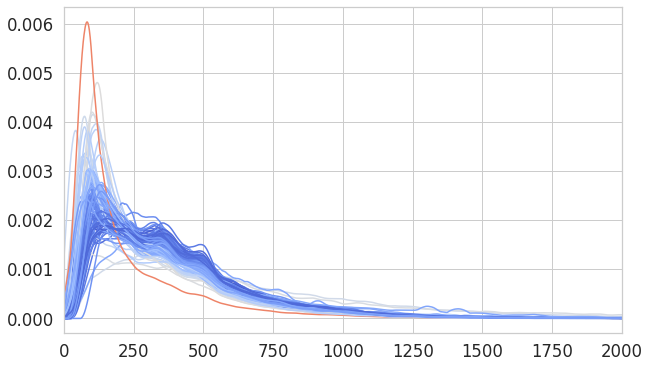

In [22]:
#Colored according to deviation

plt.figure(figsize=(10,6))
viridis = matplotlib.cm.get_cmap('coolwarm')

for name, group in protein_df.groupby('species'):
    plotKDE(group['protein_length'], label=name, color=viridis(spec_df[spec_df['species']==name]['protein length deviation'].iloc[0]))


# Suspicious (selected) proteomes

In [23]:
#Need to better define thresholds. As for now, they are quite arbitrary.
thresholds = {'Proportion false start' : [.1,.2], 'Proportion premature stop' : [.01,0.1],
              'Proportion Fragment (annotated)' : [0.1,0.2], 'Proportion Pseudogene (annotated)' : [.1,0.2], 
              'protein length deviation' : [0.3,0.5]}


In [24]:
viz_df = spec_df.set_index('species')
s = viz_df.style

In [27]:

suspicious = list()
reasons = dict()
state = colors
for i in range(len(state)):
    for j in range(len(state[i])):
        if state[i,j] != 'safe':
            if viz_df.index[i] not in suspicious:
                suspicious.append(viz_df.index[i])
            reas_spec = reasons.get(viz_df.index[i], False)

            if not reas_spec:
                reas_spec = list()
                reasons[viz_df.index[i]] = reas_spec

                    
            reas_spec.append((spec_df.columns[j+1], state[i,j]))
susp_df = spec_df[spec_df['species'].isin(suspicious)]
susp_protein_df = protein_df[protein_df['species'].isin(suspicious)]

In [28]:
#List of proteomes passing at least one of the 'suspicious threshold' and the reasons why

print("Suspicious proteomes are : ")
for sus in suspicious:
    print(sus)
    explain = [elem[0]+": "+elem[1] for elem in reasons[sus]]
    print('Reasons : '+('; ').join(explain))
print('Automatically selected for visualization')

Suspicious proteomes are : 
Aegilops_tauschii
Reasons : Proportion false start: suspicious
Amborella_trichopoda
Reasons : protein length deviation: moderate
Ananas_comosus
Reasons : Proportion false start: moderate
Asparagus_officinalis
Reasons : protein length deviation: moderate
Brassica_nigra
Reasons : protein length deviation: moderate
Chara_braunii
Reasons : protein length deviation: moderate
Chlamydomonas_reinhardtii
Reasons : protein length deviation: moderate
Chondrus_crispus
Reasons : protein length deviation: moderate
Corchorus_capsularis
Reasons : protein length deviation: moderate
Cucumis_melo
Reasons : protein length deviation: moderate
Dioscorea_rotundata
Reasons : protein length deviation: moderate
Eragrostis_tef
Reasons : Proportion false start: suspicious
Ficus_carica
Reasons : protein length deviation: moderate
Helianthus_annuus
Reasons : protein length deviation: moderate
Oryza_glaberrima
Reasons : Proportion false start: moderate
Oryza_longistaminata
Reasons : Propo

# Histograms (with mean, quartiles labeled) of selected proteomes

In [29]:
def dist_plot_ridge(protein_df, colors= None, ref=None):
    #Plot distribution of length, GC content, and Gene length for species in taxlist, extracting data from the gendatadict. colors is the lsit of colors in which to color histograms 
    #Differs from taxplot by the style used, closer to a ridgeplot for this one.
    
    protein_by_sp =  protein_df.groupby('species')
    fig, axs = plt.subplots(len(protein_by_sp))
    fig.subplots_adjust(top=1.5)
    fig.set_figheight(len(protein_by_sp)*3)
    fig.set_figwidth(6)
    i = 0    
    for name, group in protein_df.groupby('species'):
        if colors:
            col = colors[i]
        else :
            col = 'green'
        axs[i].set_title(name, fontsize=12)
        axs[i].set_xlim(0,2000)
        axs[i].set_ylim(0,0.004)
        axs[i].set_facecolor('none')
        axs[i].spines['top'].set_visible(False)
        axs[i].spines['left'].set_visible(False)
        axs[i].spines['right'].set_visible(False)
        axs[i].xaxis.set_tick_params(labelsize=12)
        axs[i].yaxis.set_tick_params(labelsize=12)

        lengths= group['protein_length']
        limit = max(lengths)

        axs[i].hist(lengths, bins=list(range(0,limit,10)), color = col, density =True,  histtype='stepfilled', alpha=0.4, linewidth=3)
        axs[i].hist(lengths, bins=list(range(0,limit,10)), color ='black', density =True, linewidth=2, histtype='step', alpha=0.6)

        median = np.median(lengths)
        firstq = np.percentile(lengths, 25)
        thirdq = np.percentile(lengths, 75)
        mean = np.mean(lengths)
        axs[i].axvline(mean, ymax=0.2, color='blue')
        axs[i].axvline(median, ymax=0.2, color='red')
        axs[i].axvline(firstq,ymax=0.1, color='red')
        axs[i].axvline(thirdq, ymax=0.1, color='red')
  
        i+=1

    #for ax in axs[:].flat:
    #    ax.set(ylabel='Density in genome',)

    axs[-1].set_xlabel('Protein size (aa)', fontsize=12)
    #for ax in axs[:-1].flat:
    #    ax.get_xaxis().set_visible(False)
    for ax in axs.flat:
        ax.get_yaxis().set_visible(False)

    fig.tight_layout()

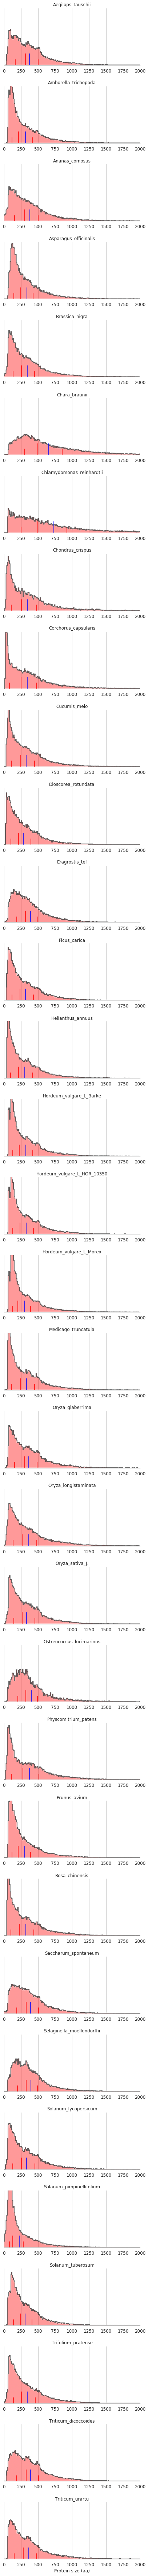

In [30]:
#This figure shows the distribution of all proteomes identified as suspicious, regardless of the reason
#Still need to plot the reference proteome as top figure. May need to discuss this part of the notebook
dist_plot_ridge(susp_protein_df, colors=['red' for x in suspicious])